In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
from tensorflow import keras

In [37]:
fmnist = keras.datasets.fashion_mnist
(fmnist_images_train, fmnist_labels_train), (fmnist_images_test, fmnist_labels_test) = fashion_mnist.load_data()

In [92]:
learning_rate = 0.0002
batch_size = 128
epochs = 100000

image_dimension = 784
generator_hidden_dimension = 256
discriminator_hidden_dimension = 256
z_noise_dimension = 100

def xavier (in_shape):
  val = tf.random.normal(shape = in_shape, stddev = 1.0/(tf.sqrt(in_shape[0]/2.0)))
  return val

In [39]:
weight = { "discriminator_hidden": tf.Variable(xavier([image_dimension, discriminator_hidden_dimension])),
           "discriminator_final": tf.Variable(xavier([discriminator_hidden_dimension, 1])),
           "generator_hidden": tf.Variable(xavier([z_noise_dimension, generator_hidden_dimension])),
           "generator_final": tf.Variable(xavier([generator_hidden_dimension, image_dimension])),
         }
bias = { "discriminator_hidden": tf.Variable(xavier([discriminator_hidden_dimension])),
         "discriminator_final": tf.Variable(xavier([1])),
         "generator_hidden": tf.Variable(xavier([generator_hidden_dimension ])),
         "generator_final": tf.Variable(xavier([image_dimension])),
       }

In [60]:
def discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weight['discriminator_hidden']), bias['discriminator_hidden']))
  final_layer = tf.add(tf.matmul(hidden_layer, weight['discriminator_final']), bias['discriminator_final'])
  disc_output = tf.nn.sigmoid(final_layer)
  return final_layer, disc_output

def generator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weight['generator_hidden']), bias['generator_hidden']))
  final_layer = tf.add(tf.matmul(hidden_layer, weight['generator_final']), bias['generator_final'])
  gen_output = tf.nn.sigmoid(final_layer)
  return final_layer, gen_output

z_input = tf.placeholder(tf.float32, shape = [None, z_noise_dimension], name = 'input_noise')
x_input = tf.placeholder(tf.float32, shape = [None, image_dimension], name = 'real_input')

with tf.name_scope('generator') as scope:
  output_gen = generator(z_input)

with tf.name_scope('discriminator') as scope:
  real_output1_disc, real_output_disc = discriminator(x_input)
  fake_output1_disc, fake_output_disc = discriminator(output_gen)

with tf.name_scope('discriminator_loss') as scope:
  discriminator_loss = -tf.reduce_mean(tf.log(real_output_disc + 0.0001) + tf.log(1.0 - fake_output_disc + 0.0001))

with tf.name_scope('generator_loss') as scope:
  generator_loss = -tf.reduce_mean(tf.log(fake_output_disc + 0.0001))

discriminator_loss_total = tf.summary.scalar("Discriminator_total_loss", discriminator_loss)
generator_loss_total = tf.summary.scalar("Generator_total_loss", generator_loss)


In [61]:
with tf.name_scope('discriminator_loss') as scope:
  discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = real_output1_disc, labels = tf.ones_like(real_output1_disc)))
  discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_disc, labels = tf.zeros_like(fake_output1_disc)))
  discriminator_loss = discriminator_real_loss + discriminator_fake_loss

with tf.name_scope('generator_loss') as scope:
  generator_loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_output1_disc, labels = tf.ones_like(fake_output1_disc)))

disc_loss_real_summary = tf.summary.scalar("Discriminator_real_loss", discriminator_real_loss)
disc_loss_fake_summary = tf.summary.scalar("Discriminator_fake_loss", discriminator_fake_loss)
disc_loss_summary = tf.summary.scalar("Discriminator_loss", discriminator_loss)

#discriminator_loss_total = tf.summary.merge(disc_loss_real_summary, disc_loss_fake_summary, disc_loss_summary)
generator_loss_total = tf.summary.scalar('Generator_total_loss', generator_loss)

In [62]:
generator_vars = [weight['generator_hidden'], weight['generator_final'],
            bias['generator_hidden'], bias['generator_final']]

discriminator_vars = [weight['discriminator_hidden'], weight['discriminator_final'],
            bias['discriminator_hidden'], bias['discriminator_final']]



In [63]:
with tf.name_scope('optimizer_discriminator') as scope:
  discriminator_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(discriminator_loss, var_list = discriminator_vars)

with tf.name_scope('optimizer_generator') as scope:
  generator_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(generator_loss, var_list = generator_vars)


In [64]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle),np.asarray(labels_shuffle)

In [96]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  x_batch = np.reshape(next_batch(batch_size,fmnist_images_train,fmnist_labels_train)[0], [-1, 784])
  z_noise = np.random.uniform(-1.0, 1.0, size = (batch_size, z_noise_dimension))
  _, discriminator_loss_epoch = sess.run([discriminator_optimizer, discriminator_loss], feed_dict = {x_input : x_batch, z_input: z_noise})
  _, generator_loss_epoch = sess.run([generator_optimizer, generator_loss], feed_dict = {z_input: z_noise})

  summary_discriminator_loss = sess.run(discriminator_loss_total, feed_dict = {x_input : x_batch, z_input: z_noise})
  writer.add_summary(summary_discriminator_loss, epoch)

  summary_generator_loss = sess.run(generator_loss_total, feed_dict = {z_input: z_noise})
  writer.add_summary(summary_generator_loss, epoch)

  if epoch%1000 ==0:
    print("Steps: {0}, Generator Loss: {1}, Discriminator Loss: {2}".format(epoch, generator_loss_epoch, discriminator_loss_epoch))


KeyboardInterrupt: ignored

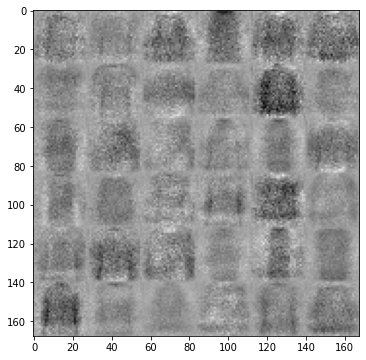

In [97]:
n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  z_noise = np.random.uniform(-1.0,1.0, size = (batch_size, z_noise_dimension))
  q, _ = sess.run(output_gen, feed_dict = {z_input: z_noise})
  q = -1 *(q-1)
  for j in range(n):
    canvas[i*28 : (i+1)*28, j*28 : (j+1)*28] = q[j].reshape([28,28])
plt.figure(figsize = (n,n))
plt.imshow(canvas, origin = 'upper', cmap = 'gray')
plt.show()